In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import tes_analysis_tools as tat
import sklearn
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import Counter
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.utilities.distribution import MultiprocessingDistributor
sns.set()

In [175]:
dir = "../WF/exp1/"
savedir = "./exp1_result/"
pulse = np.load(dir + "pulse.npy")
noise = np.load(dir + "noise.npy")
time  = np.load(dir + "time.npy")

n  = pulse.shape[0]
dp = pulse.shape[1]
m  = noise.shape[0]
dt = time[1] - time[0]

# baseline 補正, 先頭からdpbl点の平均をoffsetとして引き去る
dpbl = 200
pulse = tat.correct_baseline(pulse, dpbl)

# 正負反転
pulse = -1.0 * pulse

# Utils

## 波形のノイズ除去のための回帰処理

In [176]:
def regression(data):
    fit = np.polyfit(time, data, 18)
    fit_fn = np.poly1d(fit)
    return fit_fn(time)

def plot_regression_curve(x, y, n=18):
    fit = np.polyfit(x, y, n)
    fit_fn = np.poly1d(fit)
    plt.plot(x, y, label="data")
    plt.plot(x, fit_fn(x), label="regression")
    plt.legend()
    plt.show()

# クラスタリング

In [177]:
df = pd.DataFrame(pulse)
df.index.name = "id"
df_corrected = df.apply(regression, axis=1, result_type="expand")
# 主成分分析
pca_model = PCA(n_components=2)
X_pca = pca_model.fit_transform(df_corrected.values)
pca_df = pd.DataFrame(data=X_pca, index=df_corrected.index, columns=["first_component", "second_component"])

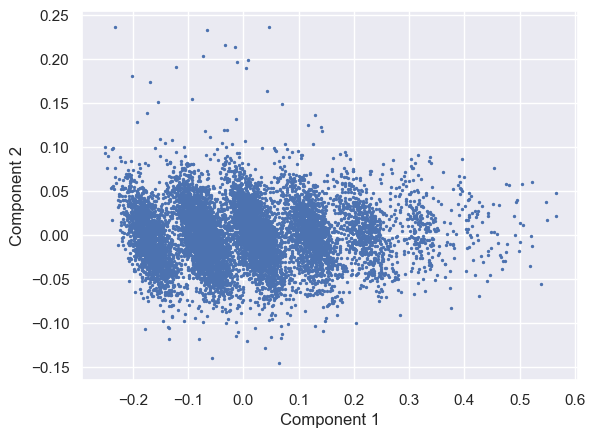

In [178]:
plt.scatter(pca_df["first_component"], pca_df["second_component"], s=2)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [179]:
# K-Means
kmeans_model = KMeans(n_clusters=6)
y_pred_kmeans = kmeans_model.fit_predict(pca_df.values)

# DBSCAN
dbscan_model = DBSCAN(eps=0.014, min_samples=100)
y_pred_dbscan = dbscan_model.fit_predict(pca_df.values)

pca_df["kmeans_pred"] = y_pred_kmeans
pca_df["dbscan_pred"] = y_pred_dbscan

c:\Users\keisu\UTokyo\RyoikiProject\PhotonClustering\photon_clustering_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [180]:
# 第一主成分の平均値が低いクラスタから0, 1, ...と再ラベリング
def relabel_by_first_comonent_avg(label_col, pca_df):
    relabeled_pca_df = pca_df.copy()
    first_component_avg_per_cluster = {}
    for label in set(pca_df[label_col]):
        if label != -1:
            first_component_avg_per_cluster[label] = pca_df[pca_df[label_col]==label]["first_component"].mean() 
    sorted_keys = sorted(first_component_avg_per_cluster, key=lambda x: first_component_avg_per_cluster[x])
    relabel_dict = {k: v for v, k in enumerate(sorted_keys)}
    relabel_dict[-1] = -1
    relabeled_pca_df[label_col] = relabeled_pca_df[label_col].map(relabel_dict)
    return relabeled_pca_df

pca_df = relabel_by_first_comonent_avg("kmeans_pred", pca_df)
pca_df = relabel_by_first_comonent_avg("dbscan_pred", pca_df)

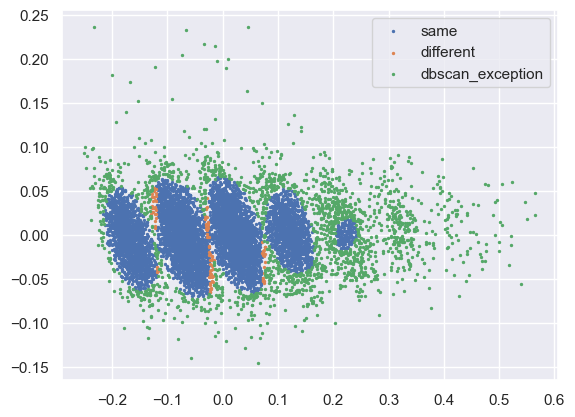

In [181]:
# K-MeansとDBSCANで予測が同じもの、異なるものを確認
same_pred = pca_df[pca_df["kmeans_pred"]==pca_df["dbscan_pred"]]
different_pred = pca_df[(pca_df["dbscan_pred"] != pca_df["kmeans_pred"]) & (pca_df["dbscan_pred"] != -1)]
dbscan_exception = pca_df[pca_df["dbscan_pred"]==-1]
plt.scatter(same_pred["first_component"], same_pred["second_component"], s=2, label="same")
plt.scatter(different_pred["first_component"], different_pred["second_component"], s=2, label="different")
plt.scatter(dbscan_exception["first_component"], dbscan_exception["second_component"], s=2, label="dbscan_exception")
plt.legend()
plt.show()

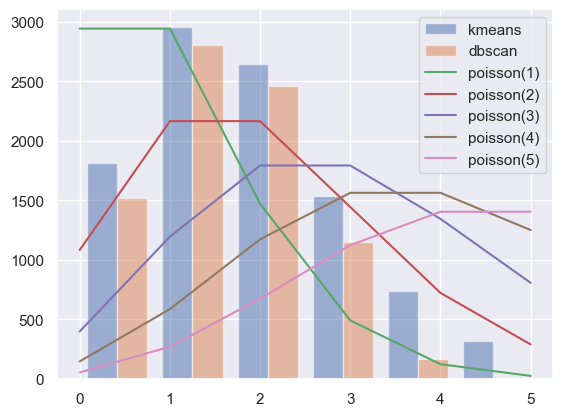

In [182]:
# クラスタのヒストグラムがpoisson分布に従っているか確認
def poisson(x, lam=1):
    return 8000 * (np.e ** (-lam)) * (lam ** x) / math.factorial(x)
x_list = np.arange(0, 6)
lam_list = range(1,6)
y_list_per_lam = {lam: [poisson(x, lam) for x in x_list] for lam in lam_list}

plt.hist([pca_df["kmeans_pred"], pca_df[pca_df["dbscan_pred"]!=-1]["dbscan_pred"]], bins=6, alpha=0.5, label=["kmeans", "dbscan"])
for lam in lam_list:
    plt.plot(x_list, y_list_per_lam[lam], label=f"poisson({lam})")
plt.legend()
plt.show()